<a href="https://colab.research.google.com/github/MaslovAleksey/Determination-of-the-car-brand-Attention-/blob/main/Determination_of_the_car_brand_(Attention).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Определение марки автомобиля по изображению** 

## **1.) Техническое описание** 



* ### **Постановка задачи:**
> #### Реализовать алгоритм опредления марки автомобиля по фото - Renault, Mercedes, Ferrari (многоклассовая кдассификация) с использованием механизма внимания (Multi Head Attention).

---

* ### **Используемые библиотеки и классы:**
> #### tensorflow, keras, numpy, matplotlib, Image, SimpleNamespace, random, math, os.

---

* ### **Специфика набора данных:**
> #### 1.   Данные содержат изображения 3-х марок автомобилей (Renault, Mercedes, Ferrari);
> #### 2.   Автомобили занимают около 65% изображения;

---

* ### **Особенности реализации алгоритма:**
> #### 1.   Для аугментации и хранения изображений используется *ImageDataGenerator*;
> #### 2.   Слои, формирующие архитектуру нейронной сети: *Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Input*;
> #### 3.   Каждый свёрточный блок состоит из *BatchNormalization, Conv2D, Conv2D, MaxPooling2D, Dropout*;
> #### 4.   Конфигурация данных формируется на основании пользовательского ввода и храниться в экземпляре класса *SimpleNamespace*;
> #### 5.   При обработке изображений используется модуль внимания.





## **2.) Подготовка данных**

### **Подключение необходимых библиотек**

In [ ]:
from google.colab import files
import numpy as np 
import matplotlib.pyplot as plt # отрисовка графиков
from PIL import Image # отрисовка изображений
import random  
import math
import os 
from types import SimpleNamespace # подкласс object, позволяющий добавлять и удалять атрибуты
from google.colab import drive
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Input, Add, Concatenate, Lambda, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator # работа с изображениями
from tensorflow.keras.optimizers import Adam, Adadelta # оптимизаторы
from tensorflow.keras import utils 
from tensorflow.keras import backend as K_back
from tensorflow.keras.preprocessing import image # отрисовка изображений
from tensorflow.keras.callbacks import ModelCheckpoint

### **Загрузка изображений с Google-диска**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/Machine learning/UAI/3.) Convolutional neural networks/Data/Автомобили.zip' # извлечение файлов из архива

### **Глобальные переменные**

In [ ]:
auto_path = '/content/Автомобили/train'
save_weights_path = '/content/drive/MyDrive/Colab Notebooks/Machine learning/UAI/29.) Attention mechanism/Weights/'
car_names = os.listdir(auto_path) # располагаем марки автомобилей в порядке следования

num = len(car_names) # количесво классов автомобилей
class_mode = "binary" if (num == 2) else "categorical" # тип выборки

img_width = 243 # ширина изображения
img_height = 162 # высота изображения
num_chnls = 3 # число каналов

### **Демонстрация изображений из набора**

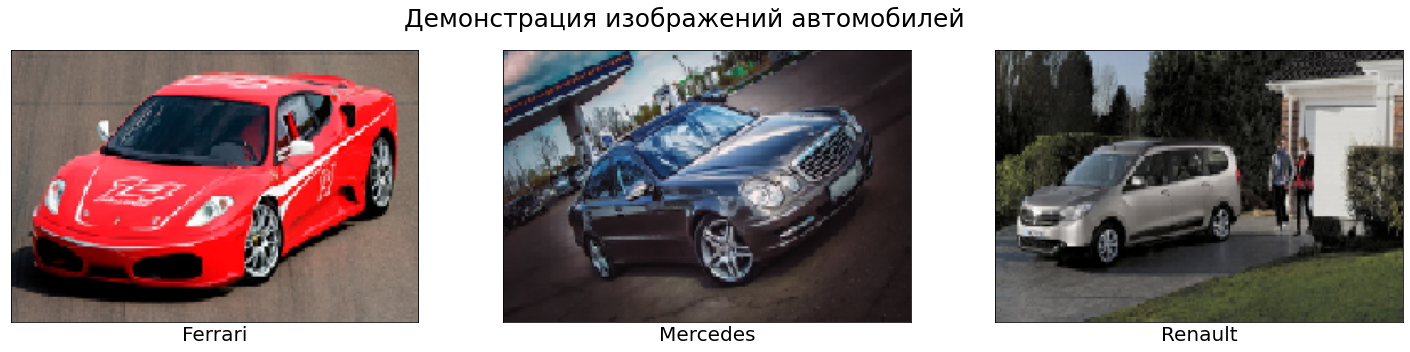

In [ ]:
fig, ax = plt.subplots(1, num, figsize=(25, 5)) # создание полотна из k графиков
fig.suptitle("Демонстрация изображений автомобилей", y=1, size=25)

for i in range(num): 
  car_path = auto_path + '/' + car_names[i] + '/' # формирование путя к выборке
  img_path = car_path + random.choice(os.listdir(car_path)) # выбор случайного фото для отображения
  

  ax[i].imshow(image.load_img(img_path, target_size=(img_height, img_width))) #Отображение фотографии

  ax[i].axes.xaxis.set_ticks([]) # инициализация тиков и меток оси пустым списком
  ax[i].get_yaxis().set_visible(False)
  ax[i].set_xlabel(car_names[i], size=20)

plt.show() # демонстрация изображений

## **2.) Необходимые функции**

### **Конфигурация данных**

In [ ]:
def create_config():
  config = SimpleNamespace()

  config.batch_size = int(input("Batch size - "))
  config.validation_split = int(input("Процент проверочной выборки - "))
  
  config.rotation_range = int(input("Поворот изображения (в градусах) - "))
  config.width_shift_range = float(input("Смещение изображения по ширине  [-1.0, +1.0) - "))
  config.height_shift_range = float(input("Смещение изображения по высоте  [-1.0, +1.0) - "))
  config.zoom_range = float(input("Коэффициент зуммирования [0.0, +1.0] - "))
  config.horizontal_flip = input("Случайное отображение относительно горизонтали (Да/Нет) - ")
  config.vertical_flip = input("Случайное отображение относительно вертикали (Да/Нет) - ")
  config.shuffle_train = input("Перемешивание тренировочной выборки (Да/Нет) - ")
  config.shuffle_val = input("Перемешивание проверочной выборки (Да/Нет) - ")

  return config

### **Формирование наборов данных**

In [ ]:
def create_data(config):
  #Генератор изображений
  datagen = ImageDataGenerator(
    rescale = 1. / 255, # нормализация изображения
    rotation_range = config.rotation_range, # поворот изображения при генерации выборки
    width_shift_range = config.width_shift_range, # смещение изображения по ширине при генерации выборки
    height_shift_range = config.height_shift_range, # смещение изображения по высоте при генерации выборки
    zoom_range = config.zoom_range, # зумирование изображения при генерации выборки
    horizontal_flip = True if config.horizontal_flip == "Да" else False, # отражение изображений относительно горизонтали
    vertical_flip = True if config.vertical_flip == "Да" else False, # отражение изображений относительно вертикали
    fill_mode = 'nearest', # заполнение пикселей вне границ ввода
    validation_split = config.validation_split / 100
    ) # разделение изображений на обучающую и тестовую выборку

  # Обучающая выборка
  train_generator = datagen.flow_from_directory(
    directory = auto_path, # путь ко всей выборке выборке
    target_size = (img_height, img_width), # размер изображений
    batch_size = config.batch_size, # размер batch_size
    class_mode = class_mode, # тип выборки 
    shuffle = True if config.shuffle_train == "Да" else False, # перемешивание выборки
    subset = 'training'
    )
  
  # Проверочная выборка
  val_generator = datagen.flow_from_directory(
    directory = auto_path, # путь ко всей выборке выборке
    target_size = (img_height, img_width), # размер изображений
    batch_size = config.batch_size, # размер batch_size
    class_mode = class_mode, # тип выборки 
    shuffle = True if config.shuffle_val == "Да" else False, # перемешивание выборки
    subset = 'validation'
    )
  
  return train_generator, val_generator

### **Вычисление функции внимания**

In [ ]:
'''

   Функция внимания позволяет сформировать вектор значений (VALUE_Attn) на основании 
соответсвия запроса (QUERY) и ключа (KEY) с целью дальнейшего суммирования с 
вектором значений (VALUE), что позволяет учитывать контекстную информацию п
ри анализе данных.

V_Attn = softmax(Q*K^T/sqrt(E))*V
V = М + V_Attn

'''

def Attn(Q, K, V, E):
  attn = tf.einsum('abc,adc -> abd', Q, K)/np.sqrt(E)
  attn = Lambda(lambda x: K_back.softmax(x, axis=-1))(attn)
  attn = tf.einsum('abc,acd -> abd', attn, V)

  return attn

### **Формирование блока внимания**

In [ ]:
'''

   Реализация механизма MultiheadAttention, позволяющего формировать несколько 
фокусов внимания при анализе информации. Каждый фокус внимания при этом нацелен 
на различные признаки в данных. 

N - число запросов
M - число ключей
Ek - размер вектора ключей (Key)
Eq - размер вектора запросов (Query)
Ev - размер векторов значений (Value)

'''

def Multi_Head_Attn(H, N, M, Ek, Eq, Ev):
  # Входные потоки
  Q = Input(shape=(N, Eq)) # shape - (N, E_q), матрица запросов - Query
  K = Input(shape=(M, Ek)) # shape - (N, E_q), матрица ключей - Key
  V = Input(shape=(M, Ev)) # shape - (N, E_q), матрица значений - Value

  Ei = Eh = Eq // H

  Q_mul = Dense(units=Ei, activation="relu")(Q) # shape - (N, E_i)
  K_mul = Dense(units=Ei, activation="relu")(Q) # shape - (N, E_i)
  V_mul = Dense(units=Eh, activation="relu")(Q) # shape - (N, E_h)

  # Определение фокусов внимания
  heads = []
  for _ in range(H):
    h = Attn(Q_mul, K_mul, V_mul, Ei)
    heads.append(h)

  out = Concatenate(axis=-1)(heads) # shape - (N, Eh*H)

  MultiHeadAttn = Model(inputs=[Q,K,V], outputs=[out])
  return MultiHeadAttn

### **Архитектура нейронной сети**

In [ ]:
'''
  Особенности архитектуры:

  1.) Нейронная сеть представляет собой последовательность аналогичных
свёрточных блоков, состоящих из следующих слоёв:
- BatchNormalization()
- Conv2D(...)
- Conv2D(...)
- MaxPooling2D(...)
- Dropout(...)

  2.) Число свёрточных фильтров возрастает в 2 раза при переходе к следующему блоку;

  3.) Блок внимания размещается после крайнего свёрточного блока, что позволяет
проанализировать максимально возможные вектора каждого отдельного пикселя 
текущего изображения.

'''



def create_network(num_blocks, num_filters, rate, num_heads):
  
  # Параметры Conv2D()
  curr_filters = num_filters # текущее число свёрточных фильтров
  kernel_size = (3,3) 
  conv_strides = (1,1) 
  conv_padding = "same"
  conv_actiavation = "relu"

  # Параметры MaxPooling2D()
  pool_size = (3,3)
  pool_strides = (3,3)
  pool_padding = "valid"

  input = Input(shape=(img_height, img_width, num_chnls)) # входной слой

  # Формирование свёрточных блоков
  for k in range(num_blocks):
    if k == 0:
      b = BatchNormalization()(input)
    else:
      b = BatchNormalization()(drop)
    conv = Conv2D(filters=curr_filters, kernel_size=kernel_size, strides=conv_strides, padding=conv_padding, activation=conv_actiavation)(b)
    conv = Conv2D(filters=curr_filters, kernel_size=kernel_size, strides=conv_strides, padding=conv_padding, activation=conv_actiavation)(conv)
    pool = MaxPooling2D(pool_size=pool_size, strides=pool_strides, padding=pool_padding)(conv)
    drop = Dropout(rate = rate)(pool)

    curr_filters *= 2 # увеличение числа свёрточных фильтров
  
  # Attention block
  if (num_heads):
    curr_height = int(img_height/(pool_size[0]**num_blocks))
    curr_width = int(img_width/(pool_size[1]**num_blocks))
    sq = curr_height * curr_width # текущая площадь изображения
    un_in = curr_filters // 2 # число свёрточных фильтров на входе в блок
    un_out = num_filters # число "свёрточных фильтров" на выходе из блока

    MultiHeadAttn = Multi_Head_Attn(H = num_heads, # число фокусов внимания
                          N = sq, # число запросов
                          M = sq, # число ключей
                          Ek = un_in, # размерность пространства KEY
                          Eq = un_in, # размерность пространства QUERY
                          Ev = un_in, # размерность пространства VALUE
                          )
    res = Reshape([sq, un_in])(drop)

    Q = res # QUERY
    K = res # KEY
    V = res # VALUE

    V_att = MultiHeadAttn([Q, K, V]) # применение механизма внимания shape - (N, E_q/H)
    V = Add()([V, V_att]) 
    x = Dense(units=un_out)(V) # shape - (N, un_out)
    x = Flatten()(x)
  
  else:
    x = Flatten()(drop)


  # Полносвязный блок
  x = Dense(units=2048)(x)
  x = Dropout(rate=rate)(x)
  x = Dense(units=512)(x)  
  x = Dropout(rate=rate)(x)

  output = Dense(units=num, activation="softmax")(x)

  conv_model = Model(inputs = input, outputs = output)

  return conv_model  

### **Визуализация процесса обучения**

In [ ]:
def training_visual(history):
  fig, ax = plt.subplots(figsize=(12,7))
  ax.set_title("Ошибка в процессе обучения", size=16, pad=20)
  ax.plot(history.history["loss"], label="тренировочные данные")
  ax.plot(history.history["val_loss"], label="проверочные данные")
  ax.set_xlabel("Число эпох", size=12)
  ax.set_ylabel("Categorical crossentropy", size=12)
  ax.legend(prop={"size":12})
  plt.show()
  
  fig, ax = plt.subplots(figsize=(12,7))
  ax.set_title("Точность в процессе обучения", size=16, pad=20)
  ax.plot(history.history["accuracy"], label="тренировочные данные")
  ax.plot(history.history["val_accuracy"], label="проверочные данные")
  ax.set_xlabel("Число эпох", size=12)
  ax.set_ylabel("Accuracy", size=12)
  ax.legend(prop={"size":12})
  plt.show()

### **Тренировка нейронной сети**

In [ ]:
def model_training(conv_model, path_weights, loss, metric, initial_epoch, epochs, learning_rate, data_callback):


  # Компиляция модели
  conv_model.compile(
      loss = loss,
      optimizer = Adam(learning_rate=learning_rate),
      metrics = [metric]
  )

  # Использование предобученных весов
  if (path_weights):
    conv_model.load_weights(path_weights)

  # Использование callback для сохранения весов
  if data_callback:
    callback = ModelCheckpoint(**data_callback)
  else:
    callback = None

  # Число шагов на эпоху
  steps_per_epoch = len(train_generator)
  val_steps = len(val_generator)


  # Процесс обучения
  history = conv_model.fit_generator(
    generator = train_generator,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_generator, 
    validation_steps = val_steps,
    callbacks = callback,
    epochs = epochs,
    verbose = 1,
    initial_epoch = initial_epoch
    )
  
  #Визуализация результатов обучения
  training_visual(history)

### **Тестирование алгоритма**

In [ ]:
def determine_auto(model, num_img, use_weights, path_weights):

  # Загрузка весов модели
  if (use_weights == "Да"):
    model.load_weights(path_weights)

  fig, ax = plt.subplots(1, num, figsize=(25, 5)) # создание полотна из k графиков
  fig.suptitle("Оценка качества работы нейронной сети", y=1, size=25)

  for i in range(num_img):
    real_name_auto = car_names[i % num] # выбор марки очередного автомобиля
    path_auto_class = auto_path + '/' + real_name_auto + '/' # путь к папке автомобилей выбранной марки
    path_auto = path_auto_class + random.choice(os.listdir(path = path_auto_class)) # путь к случайно выбранному изображению

    img = image.load_img(path_auto, target_size=(img_height, img_width)) # загрузка изображения
    img_arr = image.img_to_array(img) / 255. # img -> array
    img_arr = np.expand_dims(img_arr, axis = 0) # увеличение размерности -> (1, img_width, img_height, num_chnls)
    
    pred = np.squeeze(model.predict(img_arr)) # предсказание нейронной сети
    pred_name_auto = car_names[np.argmax(pred, axis=0)]

    x_label = f"Марка авто - {real_name_auto}\n Предсказание нейронной сети - {pred_name_auto}"

    ax[i].imshow(img) 

    ax[i].axes.xaxis.set_ticks([]) # инициализация тиков и меток оси пустым списком
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_xlabel(x_label, size=20)

  plt.show() # демонстрация изображений

## **3.) Реализация алгоритма классификации** 

### **Формирование наборов данных**

In [ ]:
config = create_config() # конфигурация данных

Batch size - 16
Процент проверочной выборки - 20
Поворот изображения (в градусах) - 10
Смещение изображения по ширине  [-1.0, +1.0) - 0.1
Смещение изображения по высоте  [-1.0, +1.0) - -0.15
Коэффициент зуммирования [0.0, +1.0] - 0.1
Случайное отображение относительно горизонтали (Да/Нет) - Да
Случайное отображение относительно вертикали (Да/Нет) - Да
Перемешивание тренировочной выборки (Да/Нет) - Да
Перемешивание проверочной выборки (Да/Нет) - Да


In [ ]:
train_generator, val_generator = create_data(config) # формирование выборок

Found 2743 images belonging to 3 classes.
Found 684 images belonging to 3 classes.


In [ ]:
print(f"\033[1mРазмер тренировочгой выборки\033[0m - {train_generator.samples}")
print(f"\033[1mРазмер проверочной выборки\033[0m - {val_generator.samples}")
print(f"\033[1mРазмерность батча\033[0m - {val_generator[0][0].shape}")

Размер тренировочгой выборки - 2743
Размер проверочной выборки - 684
Размерность батча - (16, 162, 243, 3)


### **Создание нейронной сети** 

In [ ]:
num_blocks = int(input("Число свёрточных блоков (не более 5) - "))
num_filters = int(input("Количество фильтров на 1-м свёрточном слое - "))
rate = float(input("Коэффициент отключения нейронов (dropout rate) [0; 1] - "))

num_heads = None
use_Attn = input("Необходимо ли использовать модуль внимания? (да/нет) - ")
if (use_Attn == "да"):
  num_heads = int(input("Число фокусов внимания - "))

Число свёрточных блоков (не более 5) - 4
Количество фильтров на 1-м свёрточном слое - 128
Коэффициент отключения нейронов (dropout rate) [0; 1] - 0.3
Необходимо ли использовать модуль внимания? (да/нет) - да
Число фокусов внимания - 1


In [ ]:
conv_model = create_network(num_blocks, num_filters, rate, num_heads)

Визуализация архитектуры нейронной сети


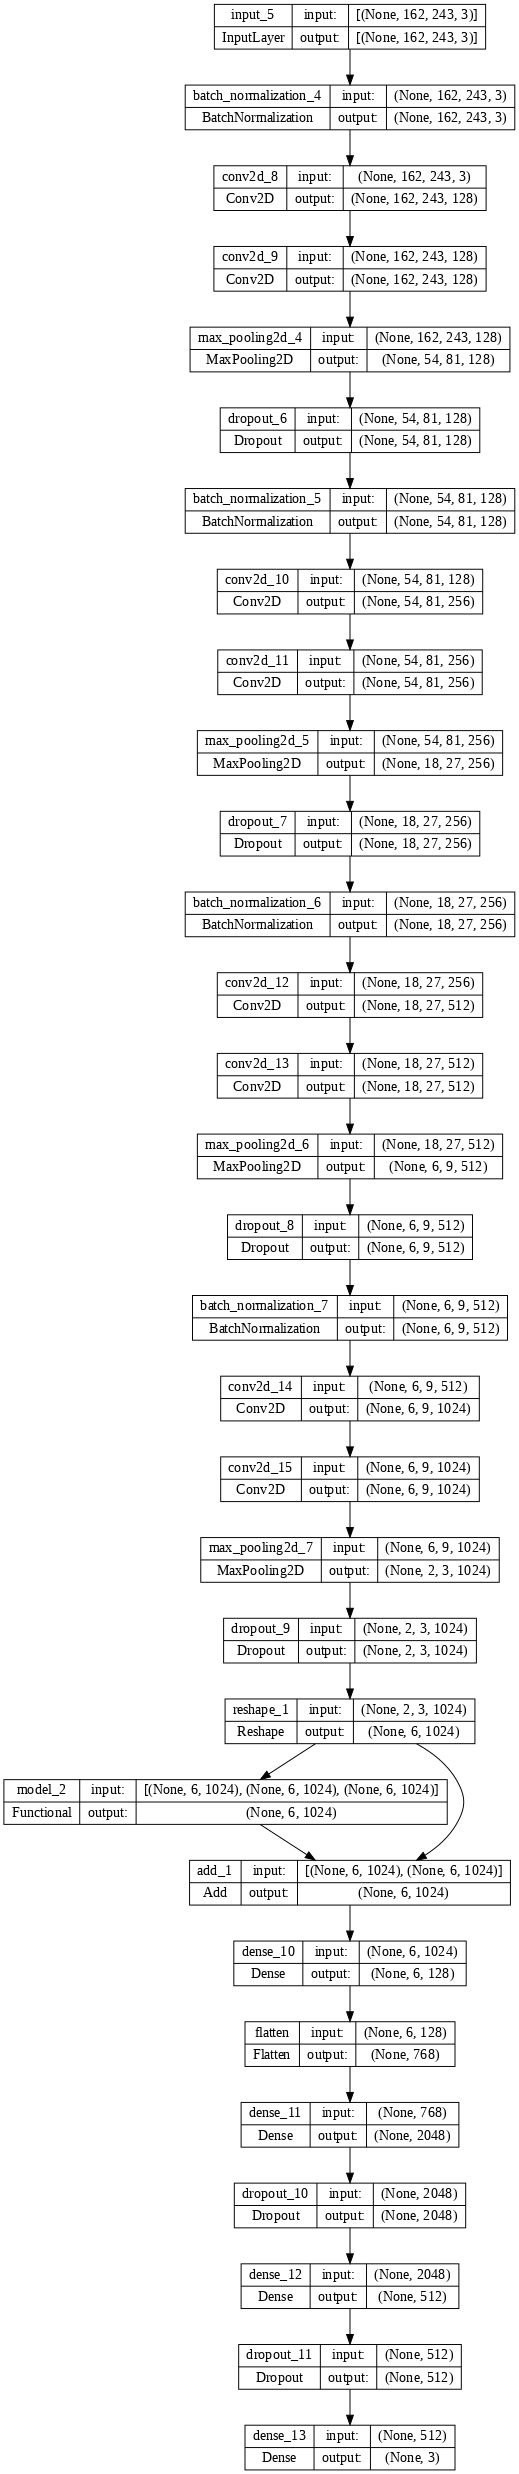

In [ ]:
print("\033[1mВизуализация архитектуры нейронной сети\033[0m")
utils.plot_model(conv_model, show_shapes=True, dpi=70)

In [ ]:
print("\033[1mВнутренняя структура модели\033[0m")
conv_model.summary()

Внутренняя структура модели
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 162, 243, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 162, 243, 3)  12         ['input_5[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 conv2d_8 (Conv2D)              (None, 162, 243, 12  3584        ['batch_normalization_4[0][0]']  
                                8)                              

### **Неизменяемые параметры обучения**

In [ ]:
loss = input("Ошибка обучения - ") # categorical_crossentropy
metric = input("Метрика точноти - ") # accuracy

Ошибка обучения - categorical_crossentropy
Метрика точноти - accuracy


### **Обучение модели (1-й этап)**

In [ ]:
epochs = int(input("Количество эпох обучения - "))
initial_epoch = int(input("Стартовая эпоха обучения - "))
learning_rate = float(input("Шаг обучения - "))

data_callback = {}
need_callback = input("Необходимо ли сохранять веса с наилучшими показателями? (Да/Нет) - ")
if (need_callback == "Да"):
  data_callback["filepath"] = save_weights_path + f"conv_attn_lr_{learning_rate}_ep_{initial_epoch}_{epochs}_.h5"
  data_callback["monitor"] = input("Оцениваемый параметр для сохранения весов (val_loss, val_accuracy) - ")
  data_callback["mode"] = input("Условие сохранения весов (min, max) - ")
  data_callback["save_best_only"] = True
  data_callback["save_weights_only"] = True
else:
  data_callback = None

Количество эпох обучения - 50
Стартовая эпоха обучения - 0
Шаг обучения - 1e-4
Необходимо ли сохранять веса с наилучшими показателями? (Да/Нет) - Да
Оцениваемый параметр для сохранения весов (val_loss, val_accuracy) - val_loss
Условие сохранения весов (min, max) - min


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


172/172 [==============================] - 66s 307ms/step - loss: 1.6571 - accuracy: 0.4313 - val_loss: 1.1449 - val_accuracy: 0.3392
Epoch 2/50
172/172 [==============================] - 46s 264ms/step - loss: 1.0435 - accuracy: 0.4987 - val_loss: 1.1543 - val_accuracy: 0.3392
Epoch 3/50
172/172 [==============================] - 46s 266ms/step - loss: 0.9564 - accuracy: 0.5414 - val_loss: 1.0425 - val_accuracy: 0.4342
Epoch 4/50
172/172 [==============================] - 45s 259ms/step - loss: 0.9284 - accuracy: 0.5505 - val_loss: 1.1018 - val_accuracy: 0.4459
Epoch 5/50
172/172 [==============================] - 46s 269ms/step - loss: 0.8839 - accuracy: 0.5793 - val_loss: 0.9423 - val_accuracy: 0.5614
Epoch 6/50
172/172 [==============================] - 44s 256ms/step - loss: 0.8631 - accuracy: 0.5797 - val_loss: 0.9969 - val_accuracy: 0.5000
Epoch 7/50
172/172 [==============================] - 45s 260ms/step - loss: 0.8430 - accuracy: 0.6190 - val_loss: 1.2708 - val_accuracy: 0.4

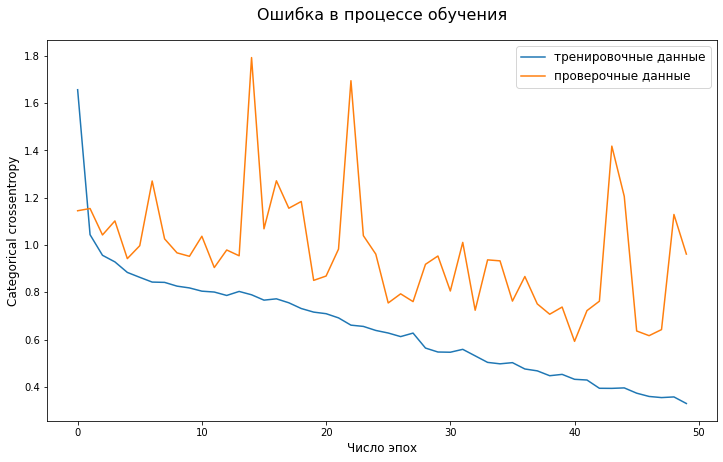

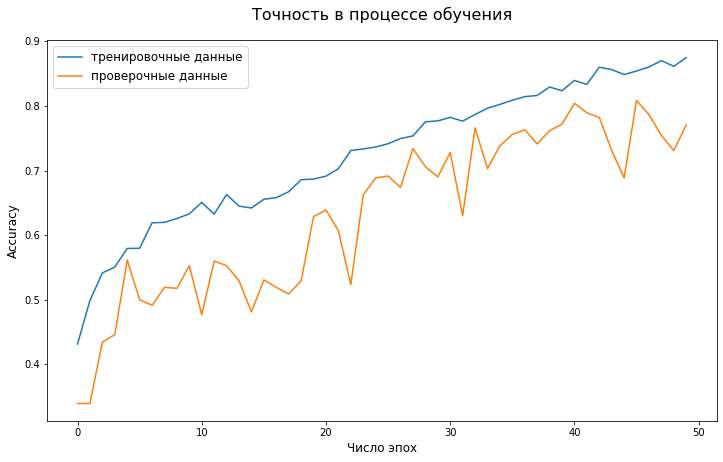

In [ ]:
model_training(conv_model, loss, metric, initial_epoch, epochs, learning_rate, data_callback)

### **Обучение модели (2-й этап)**

In [ ]:
path_weights = None
use_weights = input("Необходимо ли использовать преобученные веса (Да/Нет) - ")
if (use_weights == "Да"):
  path_weights = input("Путь к весам модели - ")

epochs = int(input("Количество эпох обучения - "))
initial_epoch = int(input("Стартовая эпоха обучения - "))
learning_rate = float(input("Шаг обучения - "))

data_callback = {}
need_callback = input("Необходимо ли сохранять веса с наилучшими показателями? (Да/Нет) - ")
if (need_callback == "Да"):
  data_callback["filepath"] = save_weights_path + f"conv_attn_lr_{learning_rate}_ep_{initial_epoch}_{epochs}_.h5"
  data_callback["monitor"] = input("Оцениваемый параметр для сохранения весов (val_loss, val_accuracy) - ")
  data_callback["mode"] = input("Условие сохранения весов (min, max) - ")
  data_callback["save_best_only"] = True
  data_callback["save_weights_only"] = True
else:
  data_callback = None

Необходимо ли использовать преобученные веса (Да/Нет) - Да
Путь к весам модели - /content/drive/MyDrive/Colab Notebooks/Machine learning/UAI/29.) Attention mechanism/Weights/conv_attn_lr_0.0001_ep_0_50_.h5
Количество эпох обучения - 70
Стартовая эпоха обучения - 50
Шаг обучения - 1e-5
Необходимо ли сохранять веса с наилучшими показателями? (Да/Нет) - Да
Оцениваемый параметр для сохранения весов (val_loss, val_accuracy) - val_loss
Условие сохранения весов (min, max) - min


Epoch 51/70


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


172/172 [==============================] - 45s 254ms/step - loss: 0.3585 - accuracy: 0.8596 - val_loss: 0.6239 - val_accuracy: 0.8041
Epoch 52/70
172/172 [==============================] - 44s 258ms/step - loss: 0.3282 - accuracy: 0.8684 - val_loss: 0.6621 - val_accuracy: 0.7895
Epoch 53/70
172/172 [==============================] - 45s 262ms/step - loss: 0.3047 - accuracy: 0.8873 - val_loss: 0.6571 - val_accuracy: 0.7953
Epoch 54/70
172/172 [==============================] - 45s 260ms/step - loss: 0.3198 - accuracy: 0.8757 - val_loss: 0.5930 - val_accuracy: 0.8158
Epoch 55/70
172/172 [==============================] - 44s 257ms/step - loss: 0.2983 - accuracy: 0.8859 - val_loss: 0.6520 - val_accuracy: 0.7982
Epoch 56/70
172/172 [==============================] - 51s 297ms/step - loss: 0.2924 - accuracy: 0.8899 - val_loss: 0.6631 - val_accuracy: 0.7968
Epoch 57/70
172/172 [==============================] - 47s 273ms/step - loss: 0.2841 - accuracy: 0.8910 - val_loss: 0.6395 - val_accurac

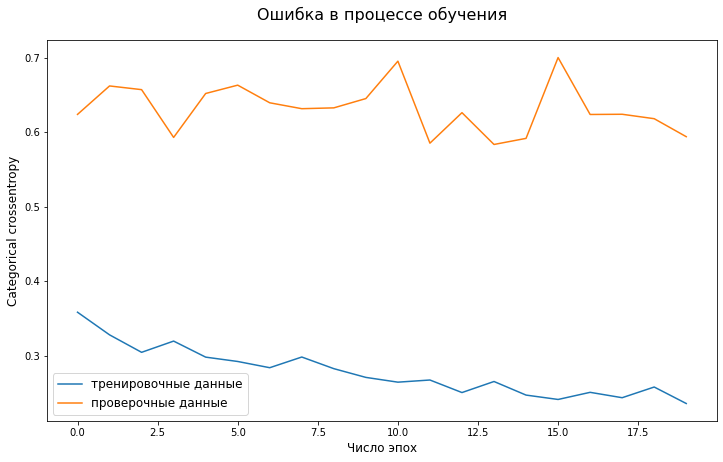

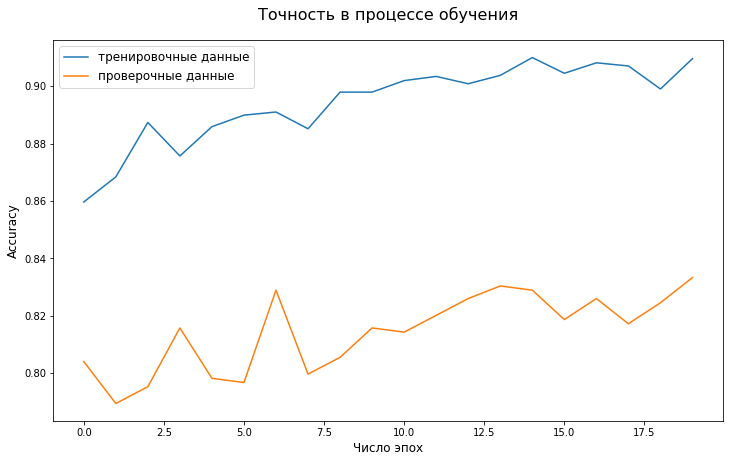

In [ ]:
model_training(conv_model, path_weights, loss, metric, initial_epoch, epochs, learning_rate, data_callback)

## **4.) Классификация автомобилей**

In [ ]:
num_img = int(input("Число изображений для анадиза - "))

path_weights = None
use_weights = input("Необходимо ли использовать преобученные веса (Да/Нет) - ")
if (use_weights == "Да"):
  path_weights = input("Путь к весам модели - ")

Число изображений для анадиза - 3
Необходимо ли использовать преобученные веса (Да/Нет) - Нет


1/1 [==============================] - 0s 29ms/step


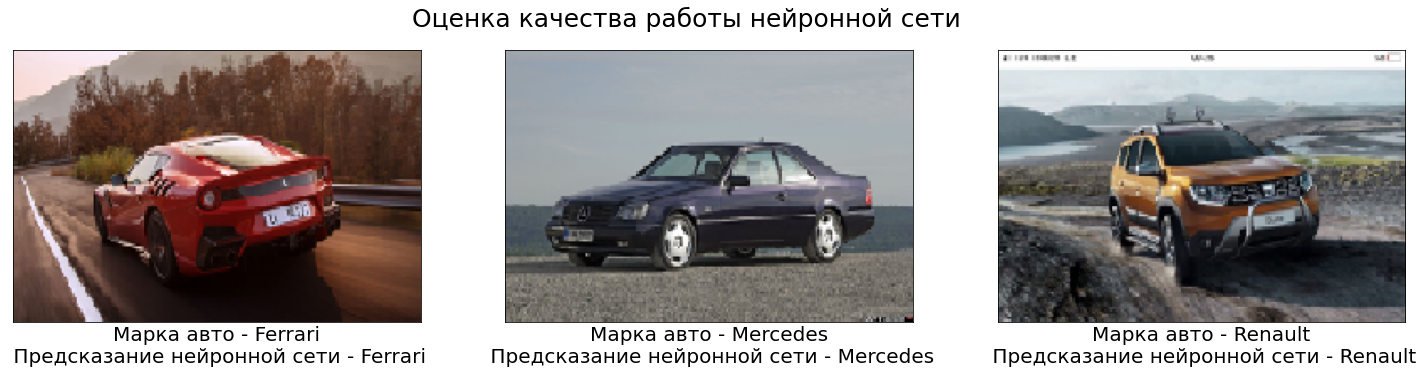

In [ ]:
determine_auto(conv_model, num_img, use_weights, path_weights)

## **5.) Выводы по проделанной работе**

>#### 1.   Увеличение числа фильтров на свёрточных слоях Conv2D(...) значительно увеличивает время обучения.
>#### 2.   При тестировании нейронной сети данные необходимо подвегать предобратке аналогичной ImageDataGenerator.
>#### 3.   В метод *datagen.flow_from_directory* в качестве параметра *target_size* подаётся кортеж *(img_height, img_width)*
>#### 4.   Входной слой нейронной сети должен принимать параметры изображения в следующей последовательности *Input(shape=(img_height, img_width, num_chnls))*
>#### 5.   Опытным путём были подобраны следующие гиперпараметры:
*   batch_size = 8
*   learning_rate = 1e-4
*   число фильтров на 1-м свёрточном слое = 128
*   количество свёрточных блоков = 4

>#### 6.   Механизм внимания обеспечивает выход сети на весьма высокую точность на проверочной выборке -  83%





